In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
import json
from datetime import datetime, timedelta
from dataclasses import dataclass, asdict
from typing import List, Dict, Tuple

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import xgboost as xgb
import shap

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
np.random.seed(42)

In [1]:
!pip install --upgrade shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.2 MB/s eta 0:00:0000:01
  Attempting uninstall: shap
    Found existing installation: shap 0.49.1
    Uninstalling shap-0.49.1:
      Successfully uninstalled shap-0.49.1


In [3]:
# Define data structures for user financial profile

@dataclass
class IncomeStream:
    type: str  # 'salary', 'freelance', 'business', 'rental'
    amount: float
    frequency: str  # 'monthly', 'weekly', 'irregular'
    reliability: str  # 'high', 'medium', 'low'
    growth_rate: float  # annual % (can be negative)

@dataclass
class FutureIncome:
    type: str  # 'inheritance', 'bonus', 'asset_sale'
    expected_date: str
    expected_amount: float
    confidence: str  # 'high', 'medium', 'low'

@dataclass
class ExpenseCategory:
    category: str  # 'fixed', 'semi-fixed', 'variable'
    subcategory: str  # 'rent', 'food', 'transport', etc.
    monthly_baseline: float
    seasonal_multipliers: Dict[int, float]  # month -> multiplier
    volatility: float  # std deviation as % of baseline

@dataclass
class RecurringObligation:
    type: str  # 'loan', 'credit_card', 'subscription'
    monthly_amount: float
    remaining_months: int

@dataclass
class LifeEvent:
    name: str  # 'ramadan', 'eid_fitr', 'eid_adha', 'school_start', 'summer_vacation'
    start_month: int  # 1-12
    duration_months: int
    expense_impact: float  # additional expense

@dataclass
class UserProfile:
    # Identity
    user_id: str
    household_size: int
    marital_status: str  # 'single', 'married', 'divorced'
    dependents: int
    region: str  # 'Tunis', 'Sfax', 'Sousse', etc.
    employment_type: str  # 'salaried', 'freelancer', 'business_owner', 'unemployed'
    pay_frequency: str  # 'monthly', 'weekly', 'irregular'
    
    # Financial state
    current_balance: float
    income_streams: List[IncomeStream]
    future_incomes: List[FutureIncome]
    expenses: List[ExpenseCategory]
    obligations: List[RecurringObligation]
    life_events: List[LifeEvent]
    
    # Loan request
    loan_amount: float
    loan_duration_months: int
    loan_interest_rate: float

## Synthetic Data Generator

Creates realistic borrower profiles based on Tunisian economic patterns
Generates 2000 diverse profiles covering low/medium/high risk scenarios.

In [4]:
# Synthetic data generator for Tunisian context

class SyntheticProfileGenerator:
    def __init__(self, n_profiles=2000):
        self.n_profiles = n_profiles
        self.regions = ['Tunis', 'Sfax', 'Sousse', 'Ariana', 'Nabeul', 'Kairouan']
        
    def generate_income_streams(self, employment_type, avg_income):
        """Generate realistic income streams based on employment type"""
        streams = []
        
        if employment_type == 'salaried':
            streams.append(IncomeStream(
                type='salary',
                amount=avg_income * np.random.uniform(0.9, 1.1),
                frequency='monthly',
                reliability='high',
                growth_rate=np.random.uniform(0, 5)  # 0-5% annual growth
            ))
        elif employment_type == 'freelancer':
            streams.append(IncomeStream(
                type='freelance',
                amount=avg_income * np.random.uniform(0.7, 1.3),
                frequency='irregular',
                reliability=np.random.choice(['medium', 'low'], p=[0.6, 0.4]),
                growth_rate=np.random.uniform(-10, 15)
            ))
        elif employment_type == 'business_owner':
            streams.append(IncomeStream(
                type='business',
                amount=avg_income * np.random.uniform(0.6, 1.5),
                frequency='monthly',
                reliability=np.random.choice(['high', 'medium', 'low'], p=[0.3, 0.5, 0.2]),
                growth_rate=np.random.uniform(-5, 20)
            ))
        
        # Add secondary income stream for some profiles
        if np.random.random() < 0.3:
            streams.append(IncomeStream(
                type=np.random.choice(['rental', 'freelance', 'investment']),
                amount=avg_income * np.random.uniform(0.1, 0.3),
                frequency='monthly',
                reliability=np.random.choice(['high', 'medium', 'low'], p=[0.4, 0.4, 0.2]),
                growth_rate=np.random.uniform(-5, 10)
            ))
        
        return streams
    
    def generate_expenses(self, monthly_income, household_size):
        """Generate expense categories with Tunisian cost structure"""
        expenses = []
        
        # Fixed expenses (40-60% of income)
        rent = monthly_income * np.random.uniform(0.20, 0.35)
        expenses.append(ExpenseCategory(
            category='fixed',
            subcategory='rent',
            monthly_baseline=rent,
            seasonal_multipliers={i: 1.0 for i in range(1, 13)},
            volatility=0.02
        ))
        
        # Utilities
        expenses.append(ExpenseCategory(
            category='semi-fixed',
            subcategory='utilities',
            monthly_baseline=monthly_income * 0.05,
            seasonal_multipliers={1: 1.3, 2: 1.2, 3: 1.0, 4: 0.9, 5: 0.8, 6: 1.1,
                                 7: 1.4, 8: 1.3, 9: 1.0, 10: 0.9, 11: 1.1, 12: 1.2},
            volatility=0.15
        ))
        
        # Food (scales with household size)
        food_baseline = monthly_income * 0.15 * (1 + household_size * 0.1)
        expenses.append(ExpenseCategory(
            category='variable',
            subcategory='food',
            monthly_baseline=food_baseline,
            seasonal_multipliers={i: 1.0 for i in range(1, 13)},
            volatility=0.20
        ))
        
        # Transport
        expenses.append(ExpenseCategory(
            category='variable',
            subcategory='transport',
            monthly_baseline=monthly_income * 0.08,
            seasonal_multipliers={i: 1.0 for i in range(1, 13)},
            volatility=0.25
        ))
        
        # Healthcare
        expenses.append(ExpenseCategory(
            category='semi-fixed',
            subcategory='healthcare',
            monthly_baseline=monthly_income * 0.05,
            seasonal_multipliers={i: 1.0 for i in range(1, 13)},
            volatility=0.40
        ))
        
        # School fees (if dependents exist)
        if household_size > 2:
            expenses.append(ExpenseCategory(
                category='semi-fixed',
                subcategory='education',
                monthly_baseline=monthly_income * 0.10,
                seasonal_multipliers={9: 2.5, 10: 1.5, 1: 1.2, 2: 1.0, 3: 1.0, 4: 1.0,
                                     5: 1.0, 6: 1.0, 7: 0.5, 8: 0.5, 11: 1.0, 12: 1.0},
                volatility=0.15
            ))
        
        return expenses
    
    def generate_life_events(self):
        """Generate Tunisian cultural and seasonal events"""
        events = []
        
        # Ramadan (moves each year, but let's fix for simulation)
        ramadan_month = np.random.randint(3, 5)
        events.append(LifeEvent(
            name='ramadan',
            start_month=ramadan_month,
            duration_months=1,
            expense_impact=np.random.uniform(200, 500)
        ))
        
        # Eid el Fitr
        events.append(LifeEvent(
            name='eid_fitr',
            start_month=ramadan_month + 1,
            duration_months=1,
            expense_impact=np.random.uniform(300, 800)
        ))
        
        # Eid el Adha
        events.append(LifeEvent(
            name='eid_adha',
            start_month=(ramadan_month + 3) % 12 if (ramadan_month + 3) % 12 != 0 else 12,
            duration_months=1,
            expense_impact=np.random.uniform(400, 1200)  # Sheep costs
        ))
        
        # Summer vacation
        events.append(LifeEvent(
            name='summer_vacation',
            start_month=7,
            duration_months=2,
            expense_impact=np.random.uniform(200, 600)
        ))
        
        # School start
        events.append(LifeEvent(
            name='school_start',
            start_month=9,
            duration_months=1,
            expense_impact=np.random.uniform(150, 500)
        ))
        
        return events
    
    def generate_obligations(self, monthly_income):
        """Generate existing financial obligations"""
        obligations = []
        
        # Existing loans (30% of profiles have one)
        if np.random.random() < 0.3:
            obligations.append(RecurringObligation(
                type='loan',
                monthly_amount=monthly_income * np.random.uniform(0.10, 0.25),
                remaining_months=np.random.randint(12, 60)
            ))
        
        # Credit card minimum (20% of profiles)
        if np.random.random() < 0.2:
            obligations.append(RecurringObligation(
                type='credit_card',
                monthly_amount=monthly_income * np.random.uniform(0.03, 0.08),
                remaining_months=999  # Ongoing
            ))
        
        # Subscriptions
        if np.random.random() < 0.5:
            obligations.append(RecurringObligation(
                type='subscription',
                monthly_amount=np.random.uniform(20, 100),
                remaining_months=999
            ))
        
        return obligations
    
    def generate_profile(self, user_id):
        """Generate a complete user profile"""
        
        # Demographics
        employment_type = np.random.choice(
            ['salaried', 'freelancer', 'business_owner'],
            p=[0.60, 0.25, 0.15]
        )
        household_size = np.random.choice([1, 2, 3, 4, 5, 6], p=[0.15, 0.25, 0.25, 0.20, 0.10, 0.05])
        marital_status = np.random.choice(['single', 'married', 'divorced'], p=[0.30, 0.60, 0.10])
        dependents = max(0, household_size - 2) if marital_status == 'married' else 0
        
        # Income (in Tunisian Dinar - average 1500-3500 TND/month)
        if employment_type == 'salaried':
            avg_monthly_income = np.random.uniform(1200, 3000)
        elif employment_type == 'freelancer':
            avg_monthly_income = np.random.uniform(1000, 4000)
        else:  # business_owner
            avg_monthly_income = np.random.uniform(1500, 5000)
        
        income_streams = self.generate_income_streams(employment_type, avg_monthly_income)
        total_monthly_income = sum(stream.amount for stream in income_streams)
        
        # Current balance (0.5 to 4 months of expenses)
        monthly_expenses = total_monthly_income * np.random.uniform(0.65, 0.95)
        current_balance = monthly_expenses * np.random.uniform(0.5, 4)
        
        # Future income events (20% have one)
        future_incomes = []
        if np.random.random() < 0.2:
            future_incomes.append(FutureIncome(
                type=np.random.choice(['bonus', 'inheritance', 'asset_sale']),
                expected_date=f"2026-{np.random.randint(1, 13):02d}-01",
                expected_amount=total_monthly_income * np.random.uniform(3, 12),
                confidence=np.random.choice(['high', 'medium', 'low'], p=[0.3, 0.5, 0.2])
            ))
        
        # Generate expenses, obligations, and life events
        expenses = self.generate_expenses(total_monthly_income, household_size)
        obligations = self.generate_obligations(total_monthly_income)
        life_events = self.generate_life_events()
        
        # Loan request
        loan_amount = total_monthly_income * np.random.uniform(3, 24)  # 3-24 months of income
        loan_duration = np.random.choice([12, 24, 36, 48, 60], p=[0.1, 0.3, 0.35, 0.15, 0.1])
        loan_interest_rate = np.random.uniform(7, 12)  # Annual %
        
        return UserProfile(
            user_id=f"USER_{user_id:04d}",
            household_size=household_size,
            marital_status=marital_status,
            dependents=dependents,
            region=np.random.choice(self.regions),
            employment_type=employment_type,
            pay_frequency='monthly' if employment_type == 'salaried' else 'irregular',
            current_balance=current_balance,
            income_streams=income_streams,
            future_incomes=future_incomes,
            expenses=expenses,
            obligations=obligations,
            life_events=life_events,
            loan_amount=loan_amount,
            loan_duration_months=loan_duration,
            loan_interest_rate=loan_interest_rate
        )
    
    def generate_dataset(self):
        """Generate full synthetic dataset"""
        profiles = []
        for i in range(self.n_profiles):
            profiles.append(self.generate_profile(i))
        return profiles


In [5]:
# Generate synthetic dataset
print("Generating 2000 synthetic user profiles...")
generator = SyntheticProfileGenerator(n_profiles=2000)
synthetic_profiles = generator.generate_dataset()
print(f" Generated {len(synthetic_profiles)} profiles")

# Display sample profile
sample = synthetic_profiles[0]
print("\n Sample Profile:")
print(f"ID: {sample.user_id}")
print(f"Employment: {sample.employment_type}")
print(f"Household: {sample.household_size} members, {sample.dependents} dependents")
print(f"Income streams: {len(sample.income_streams)}")
print(f"Current balance: {sample.current_balance:.2f} TND")
print(f"Loan request: {sample.loan_amount:.2f} TND over {sample.loan_duration_months} months")

Generating 2000 synthetic user profiles...
 Generated 2000 profiles

📋 Sample Profile:
ID: USER_0000
Employment: salaried
Household: 6 members, 4 dependents
Income streams: 2
Current balance: 8423.53 TND
Loan request: 18863.84 TND over 36 months


In [6]:
class FeatureEngineer:
    """Extract ML features from user profiles"""
    
    @staticmethod
    def calculate_monthly_income(profile: UserProfile) -> float:
        """Total monthly income from all streams"""
        return sum(stream.amount for stream in profile.income_streams)
    
    @staticmethod
    def calculate_monthly_expenses(profile: UserProfile) -> float:
        """Average monthly expenses (baseline, no seasonality)"""
        return sum(exp.monthly_baseline for exp in profile.expenses)
    
    @staticmethod
    def calculate_monthly_obligations(profile: UserProfile) -> float:
        """Total recurring obligations per month"""
        return sum(obl.monthly_amount for obl in profile.obligations)
    
    @staticmethod
    def calculate_loan_payment(profile: UserProfile) -> float:
        """Calculate monthly loan payment using annuity formula"""
        P = profile.loan_amount
        r = profile.loan_interest_rate / 100 / 12  # Monthly rate
        n = profile.loan_duration_months
        
        if r == 0:
            return P / n
        
        monthly_payment = P * (r * (1 + r)**n) / ((1 + r)**n - 1)
        return monthly_payment
    
    @staticmethod
    def extract_features(profile: UserProfile) -> Dict[str, float]:
        """Extract all features for ML model"""
        
        monthly_income = FeatureEngineer.calculate_monthly_income(profile)
        monthly_expenses = FeatureEngineer.calculate_monthly_expenses(profile)
        monthly_obligations = FeatureEngineer.calculate_monthly_obligations(profile)
        loan_payment = FeatureEngineer.calculate_loan_payment(profile)
        
        # Income features
        income_types = [stream.type for stream in profile.income_streams]
        has_freelance = int('freelance' in income_types)
        has_multiple_streams = int(len(profile.income_streams) > 1)
        
        reliability_scores = {'high': 1.0, 'medium': 0.6, 'low': 0.3}
        avg_income_reliability = np.mean([reliability_scores[s.reliability] for s in profile.income_streams])
        
        income_volatility = np.std([stream.amount for stream in profile.income_streams]) / monthly_income if len(profile.income_streams) > 1 else 0
        avg_income_growth = np.mean([stream.growth_rate for stream in profile.income_streams])
        
        # Expense features
        fixed_expenses = sum(e.monthly_baseline for e in profile.expenses if e.category == 'fixed')
        variable_expenses = sum(e.monthly_baseline for e in profile.expenses if e.category == 'variable')
        
        expense_volatility = np.mean([e.volatility for e in profile.expenses])
        
        # Calculate seasonal exposure
        max_seasonal_multiplier = 1.0
        for expense in profile.expenses:
            if expense.seasonal_multipliers:
                max_seasonal_multiplier = max(max_seasonal_multiplier, max(expense.seasonal_multipliers.values()))
        
        # Life event impact
        total_life_event_expense = sum(event.expense_impact for event in profile.life_events)
        max_single_event_expense = max([event.expense_impact for event in profile.life_events]) if profile.life_events else 0
        
        # Future income
        has_future_income = int(len(profile.future_incomes) > 0)
        future_income_confidence = 0
        if profile.future_incomes:
            conf_scores = {'high': 1.0, 'medium': 0.6, 'low': 0.3}
            future_income_confidence = np.mean([conf_scores[fi.confidence] for fi in profile.future_incomes])
        
        # Calculate ratios
        total_fixed_obligations = monthly_obligations + loan_payment + fixed_expenses
        debt_to_income = (monthly_obligations + loan_payment) / monthly_income if monthly_income > 0 else 999
        fixed_expense_ratio = total_fixed_obligations / monthly_income if monthly_income > 0 else 999
        expense_to_income = (monthly_expenses + monthly_obligations + loan_payment) / monthly_income if monthly_income > 0 else 999
        
        # Liquidity metrics
        total_monthly_outflow = monthly_expenses + monthly_obligations + loan_payment
        buffer_months = profile.current_balance / total_monthly_outflow if total_monthly_outflow > 0 else 0
        net_monthly_cashflow = monthly_income - total_monthly_outflow
        cashflow_margin = net_monthly_cashflow / monthly_income if monthly_income > 0 else -999
        
        # Household pressure
        dependents_per_income_stream = profile.dependents / len(profile.income_streams) if len(profile.income_streams) > 0 else 0
        income_per_household_member = monthly_income / profile.household_size if profile.household_size > 0 else 0
        
        # Loan characteristics
        loan_to_income_ratio = profile.loan_amount / (monthly_income * 12) if monthly_income > 0 else 999
        loan_payment_to_income = loan_payment / monthly_income if monthly_income > 0 else 999
        
        features = {
            # Income features
            'monthly_income': monthly_income,
            'has_freelance_income': has_freelance,
            'has_multiple_income_streams': has_multiple_streams,
            'avg_income_reliability': avg_income_reliability,
            'income_volatility': income_volatility,
            'avg_income_growth_rate': avg_income_growth,
            
            # Expense features
            'monthly_expenses': monthly_expenses,
            'fixed_expenses': fixed_expenses,
            'variable_expenses': variable_expenses,
            'expense_volatility': expense_volatility,
            'max_seasonal_multiplier': max_seasonal_multiplier,
            
            # Life events
            'total_life_event_expense': total_life_event_expense,
            'max_single_event_expense': max_single_event_expense,
            
            # Future income
            'has_future_income': has_future_income,
            'future_income_confidence': future_income_confidence,
            
            # Obligations
            'monthly_obligations': monthly_obligations,
            'num_obligations': len(profile.obligations),
            
            # Ratios & metrics
            'debt_to_income_ratio': debt_to_income,
            'fixed_expense_ratio': fixed_expense_ratio,
            'expense_to_income_ratio': expense_to_income,
            'buffer_months': buffer_months,
            'net_monthly_cashflow': net_monthly_cashflow,
            'cashflow_margin': cashflow_margin,
            
            # Household
            'household_size': profile.household_size,
            'dependents': profile.dependents,
            'dependents_per_income_stream': dependents_per_income_stream,
            'income_per_household_member': income_per_household_member,
            
            # Loan
            'loan_amount': profile.loan_amount,
            'loan_duration_months': profile.loan_duration_months,
            'loan_interest_rate': profile.loan_interest_rate,
            'loan_payment': loan_payment,
            'loan_to_income_ratio': loan_to_income_ratio,
            'loan_payment_to_income': loan_payment_to_income,
            
            # Categorical
            'is_salaried': int(profile.employment_type == 'salaried'),
            'is_freelancer': int(profile.employment_type == 'freelancer'),
            'is_business_owner': int(profile.employment_type == 'business_owner'),
            'is_married': int(profile.marital_status == 'married'),
        }
        
        return features



In [7]:
# Extract features for all profiles
print("Extracting features from profiles...")
features_list = [FeatureEngineer.extract_features(profile) for profile in synthetic_profiles]
features_df = pd.DataFrame(features_list)

print(f" Extracted {len(features_df.columns)} features from {len(features_df)} profiles")
print("\n Feature summary:")
print(features_df.describe().round(2))

Extracting features from profiles...
 Extracted 37 features from 2000 profiles

 Feature summary:
       monthly_income  has_freelance_income  has_multiple_income_streams  \
count         2000.00               2000.00                      2000.00   
mean          2547.28                  0.34                         0.31   
std           1033.30                  0.47                         0.46   
min            718.35                  0.00                         0.00   
25%           1815.96                  0.00                         0.00   
50%           2387.02                  0.00                         0.00   
75%           2984.10                  1.00                         1.00   
max           8173.95                  1.00                         1.00   

       avg_income_reliability  income_volatility  avg_income_growth_rate  \
count                 2000.00            2000.00                 2000.00   
mean                     0.80               0.10                 

# CashflowSimulator is a Monte Carlo cashflow engine.
It answers questions like:

- “Given uncertainty in income and expenses, what could this person’s financial future look like?”

- “What’s the probability their balance goes negative?”

- “Do they likely default on a loan?”

Instead of predicting one future, it simulates many possible futures and analyzes the distribution.

In [9]:
class CashflowSimulator:
    """Simulate monthly cashflow with Monte Carlo for uncertainty"""
    
    def __init__(self, profile: UserProfile, n_simulations=100):
        self.profile = profile
        self.n_simulations = n_simulations
        self.horizon_months = 24  # 2-year forward simulation
        
    def simulate_single_trajectory(self, seed=None) -> np.ndarray:
        """Simulate one possible cashflow trajectory"""
        if seed is not None:
            np.random.seed(seed)
        
        balance = np.zeros(self.horizon_months + 1)
        balance[0] = self.profile.current_balance
        
        monthly_income = FeatureEngineer.calculate_monthly_income(self.profile)
        loan_payment = FeatureEngineer.calculate_loan_payment(self.profile)
        
        for month in range(1, self.horizon_months + 1):
            # Income with reliability variation
            income = 0
            for stream in self.profile.income_streams:
                reliability_factor = {'high': (0.95, 1.05), 'medium': (0.80, 1.15), 'low': (0.60, 1.30)}
                low, high = reliability_factor[stream.reliability]
                income += stream.amount * np.random.uniform(low, high)
            
            # Expenses with volatility and seasonality
            expenses = 0
            for exp_cat in self.profile.expenses:
                seasonal_mult = exp_cat.seasonal_multipliers.get(month % 12 if month % 12 != 0 else 12, 1.0)
                volatility = np.random.normal(1.0, exp_cat.volatility)
                expenses += exp_cat.monthly_baseline * seasonal_mult * volatility
            
            # Recurring obligations
            obligations = sum(obl.monthly_amount for obl in self.profile.obligations if obl.remaining_months >= month)
            
            # Life events
            event_expense = 0
            for event in self.profile.life_events:
                event_month = event.start_month
                if month % 12 == event_month or (month % 12 == 0 and event_month == 12):
                    event_expense += event.expense_impact
            
            # Loan payment (only if within loan duration)
            loan_pmt = loan_payment if month <= self.profile.loan_duration_months else 0
            
            # Future income events
            future_income = 0
            for fut_inc in self.profile.future_incomes:
                try:
                    event_date = datetime.strptime(fut_inc.expected_date, "%Y-%m-%d")
                    months_until = (event_date.year - 2026) * 12 + event_date.month - 1
                    if month == months_until:
                        conf_factor = {'high': 1.0, 'medium': 0.8, 'low': 0.6}
                        future_income += fut_inc.expected_amount * conf_factor[fut_inc.confidence]
                except:
                    pass
            
            # Update balance
            net_cashflow = income + future_income - expenses - obligations - loan_pmt - event_expense
            balance[month] = balance[month - 1] + net_cashflow
        
        return balance
    
    def run_monte_carlo(self) -> Dict[str, np.ndarray]:
        """Run Monte Carlo simulations"""
        trajectories = np.zeros((self.n_simulations, self.horizon_months + 1))
        
        for i in range(self.n_simulations):
            trajectories[i, :] = self.simulate_single_trajectory(seed=i)
        
        # Calculate statistics
        return {
            'trajectories': trajectories,
            'p10': np.percentile(trajectories, 10, axis=0),
            'p50': np.percentile(trajectories, 50, axis=0),
            'p90': np.percentile(trajectories, 90, axis=0),
            'mean': np.mean(trajectories, axis=0),
        }
    
    def calculate_stress_probability(self, threshold=-500) -> np.ndarray:
        """Calculate probability of balance falling below threshold each month"""
        results = self.run_monte_carlo()
        trajectories = results['trajectories']
        
        stress_prob = np.zeros(self.horizon_months + 1)
        for month in range(self.horizon_months + 1):
            stress_prob[month] = np.mean(trajectories[:, month] < threshold)
        
        return stress_prob
    
    def identify_default(self, threshold=-500, consecutive_months=3) -> bool:
        """Determine if profile defaults (balance < threshold for consecutive months)"""
        results = self.run_monte_carlo()
        median_trajectory = results['p50']
        
        consecutive_count = 0
        for balance in median_trajectory:
            if balance < threshold:
                consecutive_count += 1
                if consecutive_count >= consecutive_months:
                    return True
            else:
                consecutive_count = 0
        
        return False

In [10]:
# Generate labels (default or not) using simulation
print("Running cashflow simulations to generate labels (this may take 2-3 minutes)...")

labels = []
stress_timelines = []

for i, profile in enumerate(synthetic_profiles):
    if i % 200 == 0:
        print(f"  Progress: {i}/{len(synthetic_profiles)}")
    
    simulator = CashflowSimulator(profile, n_simulations=50)  # Reduced for speed
    defaulted = simulator.identify_default(threshold=-500, consecutive_months=3)
    labels.append(int(defaulted))
    
    # Store stress timeline for later use
    stress_prob = simulator.calculate_stress_probability(threshold=-500)
    stress_timelines.append(stress_prob)

features_df['default'] = labels

print(f"\n Simulation complete")
print(f"Default rate: {100*np.mean(labels):.1f}%")
print(f"Non-default: {sum(1-np.array(labels))} profiles")
print(f"Default: {sum(labels)} profiles")

Running cashflow simulations to generate labels (this may take 2-3 minutes)...
  Progress: 0/2000
  Progress: 200/2000
  Progress: 400/2000
  Progress: 600/2000
  Progress: 800/2000
  Progress: 1000/2000
  Progress: 1200/2000
  Progress: 1400/2000
  Progress: 1600/2000
  Progress: 1800/2000

 Simulation complete
Default rate: 78.5%
Non-default: 430 profiles
Default: 1570 profiles


In [11]:
# Prepare data for ML
feature_columns = [col for col in features_df.columns if col != 'default']
X = features_df[feature_columns]
y = features_df['default']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Number of features: {len(feature_columns)}")

Training set: 1600 samples
Test set: 400 samples
Number of features: 37


## Why XGBoost for Loan Risk Assessment
1. Superior Performance on Tabular Data
2. Handles Feature Interactions Automatically
3. Robust to Missing Data & Outliers
4. Built-in Regularization
5. Explainability via SHAP

## Evaluation metrics rationale
1. Accuracy: Simple, intuitive baseline
2. Precision "When We Predict HIGH RISK, Are We Right?": 
- Reject good customer → Lost revenue
- Customer frustration → Brand damage
- Potential discrimination lawsuit
3. Recall "Of All Actual HIGH RISK, How Many Did We Catch?"
4. F1-Score: balances two business objectives:
-  Don't reject good customers (Precision)
-  Don't approve bad loans (Recall)
5. ROC-AUC Score "If I pick one LOW RISK and one HIGH RISK borrower at random, what's the probability the model scores them correctly?"


In [13]:
# Train XGBoost model
print("Training XGBoost classifier...")

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
print("\n Model Performance:")
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.3f}")


Training XGBoost classifier...

 Model Performance:
              precision    recall  f1-score   support

  No Default       0.90      0.90      0.90        86
     Default       0.97      0.97      0.97       314

    accuracy                           0.95       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.95      0.95      0.95       400


ROC-AUC Score: 0.985


##  Extract Feature Importance from XGBoost

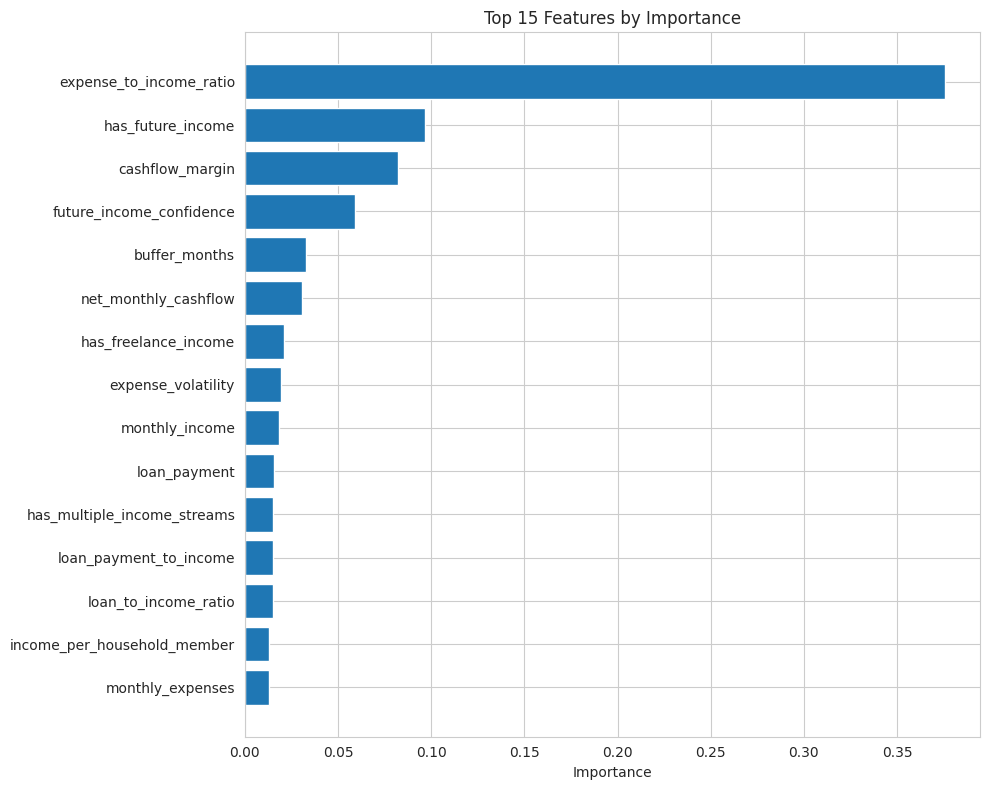


Top 10 Risk Drivers:
                 feature  importance
 expense_to_income_ratio    0.375744
       has_future_income    0.096940
         cashflow_margin    0.082217
future_income_confidence    0.059246
           buffer_months    0.032861
    net_monthly_cashflow    0.030651
    has_freelance_income    0.020782
      expense_volatility    0.019446
          monthly_income    0.018095
            loan_payment    0.015718


In [14]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.xlabel('Importance')
plt.title('Top 15 Features by Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Risk Drivers:")
print(feature_importance.head(10).to_string(index=False))

## SHAP Explainability Setup

Initialize SHAP (SHapley Additive exPlanations) to explain model predictions:

### What SHAP Does:
Breaks down each prediction into feature contributions:
```
Base risk (0.50)
+ DTI ratio (0.68): +0.25  : Increases risk
+ Buffer (0.8 months): -0.10  : Decreases risk  
+ Income volatility: +0.15  : Increases risk
= Final prediction: 0.60 (MEDIUM RISK)
```

### Why Critical:
- **Regulatory compliance**: GDPR, Fair Credit laws require explanations
- **Customer trust**: "Your DTI (68%) exceeds our threshold (50%)"
- **Model debugging**: Detect bias (e.g., unfair treatment of freelancers)

In [15]:
# Initialize SHAP explainer
print("Initializing SHAP explainer...")
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
print("SHAP values computed")

Initializing SHAP explainer...
SHAP values computed


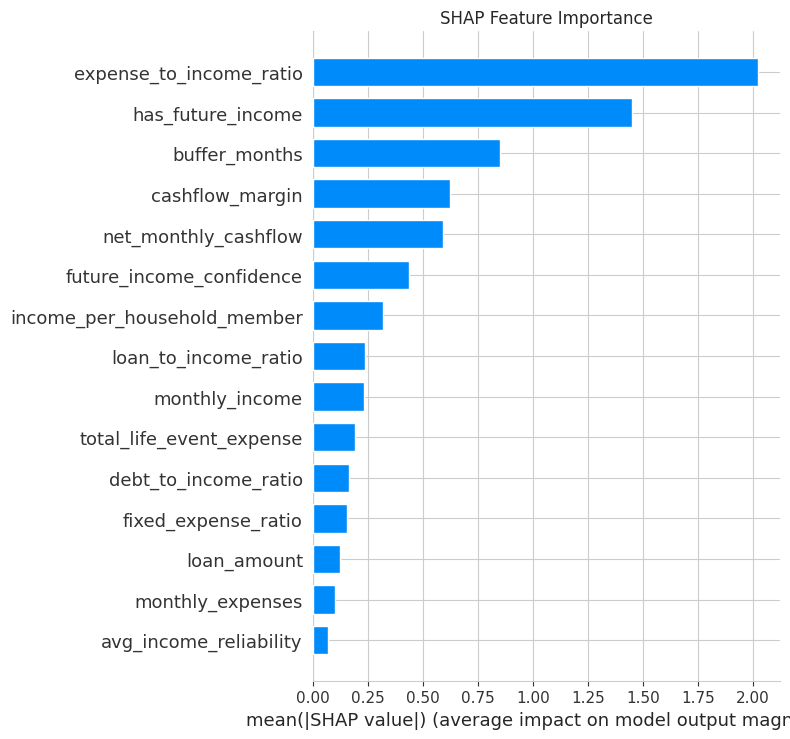

In [16]:
# SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15, show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

## The main class orchestrator for the full analysis pipeline 
- Risk scoring 
- Stress Timeline Analysis
- Risk Decomposition
- Trigger Events identification
- Banker Recommandation 

In [47]:
class StressTimelineAnalyzer:
    """Analyze and visualize when risk materializes"""
    
    def __init__(self, profile: UserProfile, model, explainer, features: Dict):
        self.profile = profile
        self.model = model
        self.explainer = explainer
        self.features = features
        self.simulator = CashflowSimulator(profile, n_simulations=200)
        
        # Cache expensive computations
        self._risk_score_cache = None
        self._risk_decomp_cache = None
        self._timeline_cache = None
    
    def get_risk_score(self) -> float:
        """Get ML risk probability (0-100)"""
        if self._risk_score_cache is None:
            X = pd.DataFrame([self.features])
            risk_prob = self.model.predict_proba(X)[0, 1]
            self._risk_score_cache = risk_prob * 100
        return self._risk_score_cache
    
    def get_stress_timeline(self) -> Dict:
        """Get monthly stress probabilities and critical windows"""
        if self._timeline_cache is None:
            stress_prob = self.simulator.calculate_stress_probability(threshold=-500)
            results = self.simulator.run_monte_carlo()
            
            # Identify critical months (>50% stress probability)
            critical_months = []
            for month in range(1, len(stress_prob)):
                if stress_prob[month] > 0.5:
                    critical_months.append({
                        'month': month,
                        'probability': stress_prob[month],
                        'median_balance': results['p50'][month]
                    })
            
            self._timeline_cache = {
                'stress_probability': stress_prob,
                'trajectories': results,
                'critical_months': critical_months
            }
        return self._timeline_cache
    
    def get_risk_decomposition(self, top_n=5):
        """Get SHAP-based risk decomposition"""
        # Convert features dict to DataFrame if needed
        if isinstance(self.features, dict):
            X = pd.DataFrame([self.features])
        elif isinstance(self.features, pd.DataFrame):
            X = self.features
        elif isinstance(self.features, pd.Series):
            X = self.features.to_frame().T
        else:
            X = pd.DataFrame([self.features])
        
        shap_vals = self.explainer(X)
        
        # Handle different SHAP value shapes
        if hasattr(shap_vals, 'values'):
            values = shap_vals.values
        else:
            values = shap_vals
        
        # Extract SHAP values for the positive class (default=1)
        if len(values.shape) == 3:
            shap_values_for_class = values[0, :, 1]
        elif len(values.shape) == 2:
            shap_values_for_class = values[0, :]
        else:
            raise ValueError(f"Unexpected SHAP values shape: {values.shape}")
        
        decomp = pd.DataFrame({
            'feature': X.columns,
            'value': X.iloc[0].values,
            'shap_value': shap_values_for_class
        })
        
        decomp['abs_shap'] = decomp['shap_value'].abs()
        
        # Convert to percentage contribution
        total_abs_shap = decomp['abs_shap'].sum()
        if total_abs_shap > 0:
            decomp['contribution_pct'] = (decomp['abs_shap'] / total_abs_shap) * 100
        else:
            decomp['contribution_pct'] = 0
        
        # Keep raw SHAP value for direction (positive = increases risk, negative = decreases risk)
        decomp['contribution'] = decomp['shap_value']
        decomp['direction'] = decomp['shap_value'].apply(lambda x: '↑ Increases Risk' if x > 0 else '↓ Decreases Risk')
        
        decomp = decomp.sort_values('abs_shap', ascending=False).head(top_n)
        
        return decomp
    
    def identify_trigger_events(self) -> List[str]:
        """Identify what events trigger stress periods"""
        triggers = []
        timeline = self.get_stress_timeline()
        
        for critical in timeline['critical_months']:
            month = critical['month']
            month_in_year = month % 12 if month % 12 != 0 else 12
            
            # Check for life events
            for event in self.profile.life_events:
                if event.start_month == month_in_year:
                    triggers.append(f"Month {month}: {event.name.replace('_', ' ').title()} (expense: {event.expense_impact:.0f} TND)")
            
            # Check for seasonal expense spikes
            for expense in self.profile.expenses:
                mult = expense.seasonal_multipliers.get(month_in_year, 1.0)
                if mult > 1.5:
                    triggers.append(f"Month {month}: High {expense.subcategory} expenses ({mult:.1f}x baseline)")
        
        return list(set(triggers))  # Remove duplicates
    
    def get_recommendation(self) -> str:
        """Generate banker recommendation"""
        risk_score = self.get_risk_score()
        timeline = self.get_stress_timeline()
        
        if risk_score < 30:
            return " LOW RISK: Approve loan as requested"
        elif risk_score < 60:
            if timeline['critical_months']:
                first_critical = timeline['critical_months'][0]['month']
                return f" MEDIUM RISK: Consider deferring loan start by {first_critical} months OR reduce loan amount by 15-20%"
            else:
                return " MEDIUM RISK: Approve with monitoring - request quarterly income verification"
        else:
            risk_decomp = self.get_risk_decomposition(top_n=3)
            top_issue = risk_decomp.iloc[0]['feature'].replace('_', ' ')
            return f" HIGH RISK: Decline or require co-signer. Main issue: {top_issue}"



## Visual dashboard for the banker

In [48]:
def create_banker_dashboard(analyzer: StressTimelineAnalyzer):
    """
    Create comprehensive visual dashboard for banker
    """
    
    # Get all analysis data
    risk_score = analyzer.get_risk_score()
    risk_decomp = analyzer.get_risk_decomposition(top_n=5)
    timeline_data = analyzer.get_stress_timeline()
    triggers = analyzer.identify_trigger_events()
    recommendation = analyzer.get_recommendation()
    
    # Create subplot figure
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Risk Score Gauge',
            'Top 5 Risk Drivers',
            '24-Month Stress Timeline',
            'Cashflow Trajectory (with uncertainty)'
        ),
        specs=[
            [{'type': 'indicator'}, {'type': 'bar'}],
            [{'type': 'scatter'}, {'type': 'scatter'}]
        ],
        vertical_spacing=0.15,
        horizontal_spacing=0.12
    )
    
    # 1. Risk Score Gauge
    color = 'green' if risk_score < 30 else 'orange' if risk_score < 60 else 'red'
    fig.add_trace(
        go.Indicator(
            mode="gauge+number",
            value=risk_score,
            title={'text': "Default Risk Score"},
            number={'suffix': '%'},  # Add percentage suffix
            gauge={
                'axis': {'range': [0, 100]},
                'bar': {'color': color},
                'steps': [
                    {'range': [0, 30], 'color': "lightgreen"},
                    {'range': [30, 60], 'color': "lightyellow"},
                    {'range': [60, 100], 'color': "lightcoral"}
                ],
                'threshold': {
                    'line': {'color': "black", 'width': 4},
                    'thickness': 0.75,
                    'value': risk_score
                }
            }
        ),
        row=1, col=1
    )
    
    # 2. Risk Drivers Bar Chart - Color by direction
    bar_colors = ['red' if x > 0 else 'green' for x in risk_decomp['contribution']]
    
    fig.add_trace(
        go.Bar(
            y=risk_decomp['feature'].apply(lambda x: x.replace('_', ' ').title()),
            x=risk_decomp['contribution_pct'],
            orientation='h',
            marker_color=bar_colors,
            text=risk_decomp.apply(
                lambda row: f"{row['contribution_pct']:.1f}% ({row['direction'].split()[0]})", 
                axis=1
            ),
            textposition='outside',
            hovertemplate='<b>%{y}</b><br>' +
                         'Contribution: %{x:.1f}%<br>' +
                         'Value: %{customdata[0]:.2f}<br>' +
                         'SHAP: %{customdata[1]:.3f}<br>' +
                         '<extra></extra>',
            customdata=risk_decomp[['value', 'contribution']].values
        ),
        row=1, col=2
    )
    
    # 3. Stress Timeline
    months = list(range(len(timeline_data['stress_probability'])))
    stress_prob = timeline_data['stress_probability'] * 100
    
    colors = ['green' if p < 30 else 'orange' if p < 60 else 'red' for p in stress_prob]
    
    fig.add_trace(
        go.Scatter(
            x=months,
            y=stress_prob,
            mode='lines+markers',
            line=dict(color='steelblue', width=2),
            marker=dict(color=colors, size=8),
            name='Stress Probability',
            fill='tozeroy',
            fillcolor='rgba(70, 130, 180, 0.2)',
            hovertemplate='Month %{x}<br>Stress Prob: %{y:.1f}%<extra></extra>'
        ),
        row=2, col=1
    )
    
    # Add threshold lines to stress timeline
    if months:  # Check if months list is not empty
        fig.add_shape(
            type="line",
            x0=0, x1=max(months),
            y0=30, y1=30,
            line=dict(color="green", width=2, dash="dash"),
            opacity=0.5,
            row=2, col=1
        )
        fig.add_shape(
            type="line",
            x0=0, x1=max(months),
            y0=60, y1=60,
            line=dict(color="red", width=2, dash="dash"),
            opacity=0.5,
            row=2, col=1
        )
    
    # 4. Cashflow Trajectory
    trajs = timeline_data['trajectories']
    
    # Confidence bands
    fig.add_trace(
        go.Scatter(
            x=months,
            y=trajs['p90'],
            mode='lines',
            line=dict(width=0),
            showlegend=False,
            hoverinfo='skip'
        ),
        row=2, col=2
    )
    
    fig.add_trace(
        go.Scatter(
            x=months,
            y=trajs['p10'],
            mode='lines',
            line=dict(width=0),
            fillcolor='rgba(0, 176, 246, 0.2)',
            fill='tonexty',
            name='80% Confidence Band',
            hovertemplate='Month %{x}<br>P10: %{y:,.0f} TND<extra></extra>'
        ),
        row=2, col=2
    )
    
    # Median trajectory
    fig.add_trace(
        go.Scatter(
            x=months,
            y=trajs['p50'],
            mode='lines',
            line=dict(color='darkblue', width=3),
            name='Median Balance',
            hovertemplate='Month %{x}<br>Balance: %{y:,.0f} TND<extra></extra>'
        ),
        row=2, col=2
    )
    
    # Zero line and stress threshold for cashflow
    if months:
        fig.add_shape(
            type="line",
            x0=0, x1=max(months),
            y0=0, y1=0,
            line=dict(color="red", width=2, dash="dash"),
            opacity=0.7,
            row=2, col=2
        )
        fig.add_shape(
            type="line",
            x0=0, x1=max(months),
            y0=-500, y1=-500,
            line=dict(color="darkred", width=2, dash="dot"),
            opacity=0.5,
            row=2, col=2
        )
    
    # Update layout
    fig.update_xaxes(title_text="Contribution %", row=1, col=2)
    fig.update_xaxes(title_text="Month", row=2, col=1)
    fig.update_xaxes(title_text="Month", row=2, col=2)
    fig.update_yaxes(title_text="Stress Probability %", row=2, col=1)
    fig.update_yaxes(title_text="Balance (TND)", row=2, col=2)
    
    fig.update_layout(
        title_text=f"Loan Risk Dashboard - {analyzer.profile.user_id}",
        title_font_size=20,
        showlegend=True,
        height=800,
        template='plotly_white'
    )
    
    fig.show()
    
    # Print text summary
    print("="*80)
    print(f"LOAN RISK ASSESSMENT SUMMARY - {analyzer.profile.user_id}")
    print("="*80)
    print(f"\n OVERALL RISK SCORE: {risk_score:.1f}%")
    print(f"\n RECOMMENDATION:\n   {recommendation}")
    
    print("\n TOP RISK DRIVERS:")
    for i, (idx, row) in enumerate(risk_decomp.iterrows(), 1):
        feature_name = row['feature'].replace('_', ' ').title()
        direction_icon = '' if row['contribution'] > 0 else '🟢'
        print(f"  {i}. {direction_icon} {feature_name}:")
        print(f"      • Contribution: {row['contribution_pct']:.1f}% of total risk")
        print(f"      • Current value: {row['value']:.2f}")
        print(f"      • Impact: {row['direction']}")
    
    print("\n CRITICAL STRESS WINDOWS:")
    if timeline_data['critical_months']:
        for critical in timeline_data['critical_months'][:5]:
            print(f"  • Month {critical['month']:2d}: {critical['probability']*100:5.1f}% stress prob | Balance: {critical['median_balance']:8,.0f} TND")
    else:
        print("  ✓ No critical stress periods identified")
    
    print("\n TRIGGER EVENTS:")
    if triggers:
        for trigger in triggers[:5]:
            print(f"  • {trigger}")
    else:
        print("  ✓ No specific trigger events identified")
    
    print("\n" + "="*80)

print(" Dashboard visualization function ready")

✅ Dashboard visualization function ready


In [49]:
# Helper function to analyze any profile
def analyze_borrower(profile_index: int):
    """Analyze a specific borrower and display dashboard"""
    profile = synthetic_profiles[profile_index]
    features = FeatureEngineer.extract_features(profile)
    
    analyzer = StressTimelineAnalyzer(profile, model, explainer, features)
    create_banker_dashboard(analyzer)
    
    return analyzer

print(" Analysis function ready")

✅ Analysis function ready


In [50]:
# Find a low-risk profile
low_risk_idx = features_df[features_df['default'] == 0].sample(1, random_state=42).index[0]
print(f"Analyzing borrower at index {low_risk_idx}...\n")
analyzer1 = analyze_borrower(low_risk_idx)

Analyzing borrower at index 1968...



LOAN RISK ASSESSMENT SUMMARY - USER_1968

🎯 OVERALL RISK SCORE: 0.1%

💡 RECOMMENDATION:
   ✅ LOW RISK: Approve loan as requested

📊 TOP RISK DRIVERS:
  1. 🟢 Expense To Income Ratio:
      • Contribution: 37.8% of total risk
      • Current value: 0.81
      • Impact: ↓ Decreases Risk
  2. 🟢 Buffer Months:
      • Contribution: 12.3% of total risk
      • Current value: 3.06
      • Impact: ↓ Decreases Risk
  3. 🟢 Cashflow Margin:
      • Contribution: 10.3% of total risk
      • Current value: 0.19
      • Impact: ↓ Decreases Risk
  4. 🟢 Net Monthly Cashflow:
      • Contribution: 10.2% of total risk
      • Current value: 448.27
      • Impact: ↓ Decreases Risk
  5. 🔴 Has Future Income:
      • Contribution: 6.4% of total risk
      • Current value: 0.00
      • Impact: ↑ Increases Risk

⚠️ CRITICAL STRESS WINDOWS:
  ✓ No critical stress periods identified

🔔 TRIGGER EVENTS:
  ✓ No specific trigger events identified



In [51]:
# Find a high-risk profile
high_risk_idx = features_df[features_df['default'] == 1].sample(1, random_state=42).index[0]
print(f"Analyzing borrower at index {high_risk_idx}...\n")
analyzer2 = analyze_borrower(high_risk_idx)

Analyzing borrower at index 1891...



LOAN RISK ASSESSMENT SUMMARY - USER_1891

🎯 OVERALL RISK SCORE: 100.0%

💡 RECOMMENDATION:
   🔴 HIGH RISK: Decline or require co-signer. Main issue: expense to income ratio

📊 TOP RISK DRIVERS:
  1. 🔴 Expense To Income Ratio:
      • Contribution: 25.6% of total risk
      • Current value: 1.78
      • Impact: ↑ Increases Risk
  2. 🔴 Has Future Income:
      • Contribution: 13.4% of total risk
      • Current value: 0.00
      • Impact: ↑ Increases Risk
  3. 🔴 Buffer Months:
      • Contribution: 12.1% of total risk
      • Current value: 0.85
      • Impact: ↑ Increases Risk
  4. 🔴 Cashflow Margin:
      • Contribution: 8.2% of total risk
      • Current value: -0.78
      • Impact: ↑ Increases Risk
  5. 🔴 Net Monthly Cashflow:
      • Contribution: 7.4% of total risk
      • Current value: -1037.73
      • Impact: ↑ Increases Risk

⚠️ CRITICAL STRESS WINDOWS:
  • Month  3: 100.0% stress prob | Balance:   -1,455 TND
  • Month  4: 100.0% stress prob | Balance:   -3,256 TND
  • Month  5:

In [52]:
# Find a medium-risk profile (40-60% risk score)
X_all = features_df[feature_columns]
risk_scores = model.predict_proba(X_all)[:, 1] * 100
medium_risk_mask = (risk_scores >= 40) & (risk_scores <= 60)
medium_risk_idx = features_df[medium_risk_mask].sample(1, random_state=42).index[0]

print(f"Analyzing borrower at index {medium_risk_idx}...\n")
analyzer3 = analyze_borrower(medium_risk_idx)

Analyzing borrower at index 274...



LOAN RISK ASSESSMENT SUMMARY - USER_0274

🎯 OVERALL RISK SCORE: 53.9%

💡 RECOMMENDATION:
   ⚠️ MEDIUM RISK: Consider deferring loan start by 19 months OR reduce loan amount by 15-20%

📊 TOP RISK DRIVERS:
  1. 🔴 Has Future Income:
      • Contribution: 19.9% of total risk
      • Current value: 0.00
      • Impact: ↑ Increases Risk
  2. 🟢 Expense To Income Ratio:
      • Contribution: 18.8% of total risk
      • Current value: 1.02
      • Impact: ↓ Decreases Risk
  3. 🟢 Buffer Months:
      • Contribution: 15.0% of total risk
      • Current value: 2.26
      • Impact: ↓ Decreases Risk
  4. 🟢 Loan To Income Ratio:
      • Contribution: 6.3% of total risk
      • Current value: 0.36
      • Impact: ↓ Decreases Risk
  5. 🔴 Net Monthly Cashflow:
      • Contribution: 5.7% of total risk
      • Current value: -40.43
      • Impact: ↑ Increases Risk

⚠️ CRITICAL STRESS WINDOWS:
  • Month 19:  59.0% stress prob | Balance:     -640 TND
  • Month 20:  55.0% stress prob | Balance:     -567 TND


In [53]:
# Analyze a specific borrower by index (change the number)
custom_idx = 100  # Change this to any number between 0 and 1999

print(f"Analyzing borrower at index {custom_idx}...\n")
analyzer_custom = analyze_borrower(custom_idx)

Analyzing borrower at index 100...



LOAN RISK ASSESSMENT SUMMARY - USER_0100

🎯 OVERALL RISK SCORE: 0.3%

💡 RECOMMENDATION:
   ✅ LOW RISK: Approve loan as requested

📊 TOP RISK DRIVERS:
  1. 🟢 Expense To Income Ratio:
      • Contribution: 36.7% of total risk
      • Current value: 0.89
      • Impact: ↓ Decreases Risk
  2. 🟢 Buffer Months:
      • Contribution: 12.4% of total risk
      • Current value: 3.13
      • Impact: ↓ Decreases Risk
  3. 🟢 Cashflow Margin:
      • Contribution: 11.3% of total risk
      • Current value: 0.11
      • Impact: ↓ Decreases Risk
  4. 🟢 Net Monthly Cashflow:
      • Contribution: 10.4% of total risk
      • Current value: 175.10
      • Impact: ↓ Decreases Risk
  5. 🔴 Has Future Income:
      • Contribution: 6.8% of total risk
      • Current value: 0.00
      • Impact: ↑ Increases Risk

⚠️ CRITICAL STRESS WINDOWS:
  ✓ No critical stress periods identified

🔔 TRIGGER EVENTS:
  ✓ No specific trigger events identified



In [54]:
# Distribution of risk scores
all_risk_scores = model.predict_proba(X)[:, 1] * 100

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=all_risk_scores,
    nbinsx=50,
    marker_color='steelblue',
    opacity=0.75
))

fig.add_vline(x=30, line_dash="dash", line_color="green", annotation_text="Low Risk Threshold")
fig.add_vline(x=60, line_dash="dash", line_color="red", annotation_text="High Risk Threshold")

fig.update_layout(
    title="Distribution of Risk Scores Across All Borrowers",
    xaxis_title="Risk Score",
    yaxis_title="Number of Borrowers",
    template='plotly_white',
    height=500
)

fig.show()

# Risk statistics
low_risk = np.sum(all_risk_scores < 30)
medium_risk = np.sum((all_risk_scores >= 30) & (all_risk_scores < 60))
high_risk = np.sum(all_risk_scores >= 60)

print("\n Portfolio Risk Distribution:")
print(f"Low Risk (<30): {low_risk} borrowers ({100*low_risk/len(all_risk_scores):.1f}%)")
print(f"Medium Risk (30-60): {medium_risk} borrowers ({100*medium_risk/len(all_risk_scores):.1f}%)")
print(f"High Risk (>60): {high_risk} borrowers ({100*high_risk/len(all_risk_scores):.1f}%)")


📊 Portfolio Risk Distribution:
Low Risk (<30): 424 borrowers (21.2%)
Medium Risk (30-60): 8 borrowers (0.4%)
High Risk (>60): 1568 borrowers (78.4%)


In [55]:
# Risk by employment type
employment_risk = []
for i, profile in enumerate(synthetic_profiles):
    employment_risk.append({
        'employment_type': profile.employment_type,
        'risk_score': all_risk_scores[i]
    })

emp_df = pd.DataFrame(employment_risk)

fig = px.box(
    emp_df,
    x='employment_type',
    y='risk_score',
    title='Risk Score Distribution by Employment Type',
    labels={'employment_type': 'Employment Type', 'risk_score': 'Risk Score'},
    color='employment_type'
)

fig.add_hline(y=30, line_dash="dash", line_color="green", opacity=0.5)
fig.add_hline(y=60, line_dash="dash", line_color="red", opacity=0.5)

fig.update_layout(template='plotly_white', height=500, showlegend=False)
fig.show()

print("\n Average Risk by Employment Type:")
print(emp_df.groupby('employment_type')['risk_score'].mean().sort_values(ascending=False))


📊 Average Risk by Employment Type:
employment_type
freelancer        79.379730
salaried          78.824265
business_owner    75.584335
Name: risk_score, dtype: float32


In [61]:
def generate_loan_report(analyzer: StressTimelineAnalyzer, output_format='dict', save_to_file=None):
    """
    Generate structured report for banker
    Can export as dict, JSON, or DataFrame
    
    Args:
        analyzer: StressTimelineAnalyzer instance
        output_format: 'dict', 'json', or 'dataframe'
        save_to_file: Optional filepath to save the report (e.g., 'report.json')
    """
    
    risk_score = analyzer.get_risk_score()
    risk_decomp = analyzer.get_risk_decomposition(top_n=5)
    timeline_data = analyzer.get_stress_timeline()
    triggers = analyzer.identify_trigger_events()
    recommendation = analyzer.get_recommendation()
    
    # Calculate additional useful metrics
    monthly_income = FeatureEngineer.calculate_monthly_income(analyzer.profile)
    loan_payment = analyzer.profile.loan_amount * (
        analyzer.profile.loan_interest_rate / 100 / 12
    ) / (1 - (1 + analyzer.profile.loan_interest_rate / 100 / 12) ** -analyzer.profile.loan_duration_months)
    
    report = {
        'user_id': str(analyzer.profile.user_id),
        'timestamp': datetime.now().isoformat(),
        'loan_request': {
            'amount': round(float(analyzer.profile.loan_amount), 2),
            'duration_months': int(analyzer.profile.loan_duration_months),
            'interest_rate': round(float(analyzer.profile.loan_interest_rate), 2),
            'estimated_monthly_payment': round(float(loan_payment), 2),
            'total_payback': round(float(loan_payment * analyzer.profile.loan_duration_months), 2),
        },
        'risk_assessment': {
            'risk_score': round(float(risk_score), 2),
            'risk_category': 'LOW' if risk_score < 30 else 'MEDIUM' if risk_score < 60 else 'HIGH',
            'recommendation': str(recommendation),
            'confidence_level': 'HIGH' if len(timeline_data['critical_months']) == 0 else 'MEDIUM' if len(timeline_data['critical_months']) < 3 else 'LOW',
        },
        'top_risk_drivers': [
            {
                'rank': idx + 1,
                'feature': str(row['feature']),
                'feature_display_name': str(row['feature']).replace('_', ' ').title(),
                'value': round(float(row['value']), 2),
                'contribution': round(float(row['contribution']), 3),
                'contribution_pct': round(float(row['contribution_pct']) if 'contribution_pct' in row else float(row['abs_shap']), 2),
                'direction': str(row['direction']) if 'direction' in row else ('increases_risk' if row['contribution'] > 0 else 'decreases_risk')
            }
            for idx, (_, row) in enumerate(risk_decomp.iterrows())
        ],
        'stress_timeline': {
            'num_critical_months': len(timeline_data['critical_months']),
            'critical_months': [
                {
                    'month': int(cm['month']),
                    'probability': round(float(cm['probability']), 3),
                    'median_balance': round(float(cm['median_balance']), 2)
                }
                for cm in timeline_data['critical_months']
            ],
            'trigger_events': [str(trigger) for trigger in triggers],
        },
        'borrower_profile': {
            'employment_type': str(analyzer.profile.employment_type),
            'household_size': int(analyzer.profile.household_size),
            'dependents': int(analyzer.profile.dependents),
            'monthly_income': round(float(monthly_income), 2),
            'current_balance': round(float(analyzer.profile.current_balance), 2),
            'debt_to_income_ratio': round(float(loan_payment / monthly_income), 3),
            'payment_to_income_ratio': round(float(loan_payment / monthly_income * 100), 2),
        },
        'metadata': {
            'model_version': 'xgboost_v1',
            'analysis_type': 'temporal_risk_lens',
            'n_simulations': 200,
        }
    }
    
    # Save to file if requested
    if save_to_file:
        if output_format == 'json':
            with open(save_to_file, 'w') as f:
                json.dump(report, f, indent=2, ensure_ascii=False)
            print(f" Report saved to: {save_to_file}")
        elif output_format == 'dataframe':
            df = pd.json_normalize(report)
            if save_to_file.endswith('.csv'):
                df.to_csv(save_to_file, index=False)
            else:
                df.to_excel(save_to_file, index=False)
            print(f" Report saved to: {save_to_file}")
    
    if output_format == 'json':
        return json.dumps(report, indent=2, ensure_ascii=False)
    elif output_format == 'dataframe':
        return pd.json_normalize(report)
    else:
        return report


In [67]:
json_report = generate_loan_report(analyzer1, output_format='json', save_to_file='/kaggle/working/loan_report_1968.json')

✅ Report saved to: /kaggle/working/loan_report_1968.json


In [68]:
print(json_report)

{
  "user_id": "USER_1968",
  "timestamp": "2026-02-01T00:43:18.319786",
  "loan_request": {
    "amount": 17046.93,
    "duration_months": 36,
    "interest_rate": 8.0,
    "estimated_monthly_payment": 534.22,
    "total_payback": 19232.02
  },
  "risk_assessment": {
    "risk_score": 0.1,
    "risk_category": "LOW",
    "recommendation": "✅ LOW RISK: Approve loan as requested",
    "confidence_level": "HIGH"
  },
  "top_risk_drivers": [
    {
      "rank": 1,
      "feature": "expense_to_income_ratio",
      "feature_display_name": "Expense To Income Ratio",
      "value": 0.81,
      "contribution": -3.808,
      "contribution_pct": 37.83,
      "direction": "↓ Decreases Risk"
    },
    {
      "rank": 2,
      "feature": "buffer_months",
      "feature_display_name": "Buffer Months",
      "value": 3.06,
      "contribution": -1.24,
      "contribution_pct": 12.32,
      "direction": "↓ Decreases Risk"
    },
    {
      "rank": 3,
      "feature": "cashflow_margin",
      "featur

In [66]:
import pickle

# Save model
with open('/kaggle/working/loan_risk_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save feature columns
with open('/kaggle/working/feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)

# Save explainer
with open('/kaggle/working/shap_explainer.pkl', 'wb') as f:
    pickle.dump(explainer, f)

print(" Model and artifacts saved successfully")
print("   - loan_risk_model.pkl")
print("   - feature_columns.pkl")
print("   - shap_explainer.pkl")

 Model and artifacts saved successfully
   - loan_risk_model.pkl
   - feature_columns.pkl
   - shap_explainer.pkl
